In [19]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import time
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy

In [20]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [21]:
# model : https://github.com/nagadomi/kaggle-cifar10-torch7

# Best MLP: ~3.7M parameters
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1) # (in_channels, out_channels, k_size)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.pool_p1 = nn.MaxPool2d(2,2,padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3,padding=1)
        self.conv5 = nn.Conv2d(128, 128, 3,padding=1)
        self.conv6 = nn.Conv2d(128, 256, 3,padding=1)
        self.fc1 = nn.Linear(256 * 5 * 5, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,10)
        
    def forward(self, x):   # scrap dropout au début
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.pool_p1(F.relu(self.conv6(x)))
        x = x.view(-1, 256*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    

In [22]:
class Net_dropout(nn.Module):
    def __init__(self):
        super(Net_dropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1) # (in_channels, out_channels, k_size)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.pool_p1 = nn.MaxPool2d(2,2,padding=1)
        self.dropout1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3,padding=1)
        self.conv5 = nn.Conv2d(128, 128, 3,padding=1)
        self.conv6 = nn.Conv2d(128, 256, 3,padding=1)
        self.fc1 = nn.Linear(256 * 5 * 5, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,10)
        
    def forward(self, x):   # scrap dropout au début
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout1(x)
        x = F.relu(self.conv5(x))
        x = self.pool_p1(F.relu(self.conv6(x)))
        x = self.dropout1(x)
        x = x.view(-1, 256*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x

In [23]:
class Net_batchnorm(nn.Module):
    def __init__(self):
        super(Net_batchnorm, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1) # (in_channels, out_channels, k_size)
        self.conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2,2)
        self.pool_p1 = nn.MaxPool2d(2,2,padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3,padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, 3,padding=1)
        self.conv6 = nn.Conv2d(128, 256, 3,padding=1)
        self.conv6_bn = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 5 * 5, 512)
        self.fc1_bn = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.fc2_bn = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,10)
        
    def forward(self, x):   # scrap dropout au début
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4_bn(self.conv4(x))))
        x = F.relu(self.conv5(x))
        x = self.pool_p1(F.relu(self.conv6_bn(self.conv6(x))))
        x = x.view(-1, 256*5*5)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2_bn(self.fc2(x)))
        x = self.fc3(x)
        
        return x

In [24]:
def accuracy(pred, y):
    correct = torch.eq(pred.max(1)[1], y).sum().type(torch.FloatTensor)
    return correct / y.size(0)

def evaluate(dataset_loader, criterion, net, optimizer):
    LOSSES = 0
    COUNTER = 0
    for batch in dataset_loader:
        optimizer.zero_grad()

        x, y = batch
        x = x.view(-1, 3, 32, 32).cuda()
        y = y.view(-1).cuda()

        loss = criterion(net(x), y)
        n = y.size(0)
        LOSSES += loss.sum().data.cpu().numpy() * n
        COUNTER += n

    return LOSSES / float(COUNTER)

In [31]:
def train(model, lr0, n_epochs, momentum=None):

    if model == 'vanilla':
        net = Net().cuda()
    if model == 'dropout':
        net = Net_dropout().cuda()
    if model == 'batchnorm':
        net = Net_batchnorm().cuda()
    
    

    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = optim.SGD(net.parameters(), lr=lr0, momentum=momentum)
    # sch = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1,2,4,6,10], gamma=gamma)

    nll_train = list()
    nll_test = list()
    acc_train = list()
    acc_test = list()

    start = time.time()
    for epoch in range(n_epochs+1):
        running_loss = 0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].cuda(), data[1].cuda()

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # sch.step()

            running_loss += loss.item()
            if i % 200 == 199:    # print every 200 mini-batches
                print('[%d, %5d] loss: %.3f' %
                    (epoch, i + 1, running_loss / 200))
                running_loss = 0.0

        # Train/test loss and accuracy computed every epoch
        nll_train.append(evaluate(trainloader, criterion, net, optimizer))
        nll_test.append(evaluate(testloader, criterion, net, optimizer))

        acc_train.append(evaluate(trainloader, accuracy, net, optimizer))
        acc_test.append(evaluate(testloader, accuracy, net, optimizer))

        print(f' [ACC] TRAIN {evaluate(trainloader, accuracy, net, optimizer)} / TEST {evaluate(testloader, accuracy, net, optimizer)}')

    print(f'Finished training in {time.time()-start}s')

    return nll_train, nll_test, acc_train, acc_test


In [32]:
n_epochs = 80
bn_trainloss, bn_testloss, bn_trainacc, bn_testacc = train('batchnorm', 0.01, n_epochs=n_epochs, momentum=0.9)
van_trainloss, van_testloss, van_trainacc, van_testacc = train('vanilla', 0.01, n_epochs=n_epochs, momentum=0.9)

[0,   200] loss: 1.518
[0,   400] loss: 1.136
[0,   600] loss: 0.945
 [ACC] TRAIN 0.72966 / TEST 0.699
[1,   200] loss: 0.733
[1,   400] loss: 0.706
[1,   600] loss: 0.679
 [ACC] TRAIN 0.8175 / TEST 0.7665
[2,   200] loss: 0.519
[2,   400] loss: 0.518
[2,   600] loss: 0.523
 [ACC] TRAIN 0.8492 / TEST 0.7828
[3,   200] loss: 0.389
[3,   400] loss: 0.400
[3,   600] loss: 0.421
 [ACC] TRAIN 0.90342 / TEST 0.8066
[4,   200] loss: 0.283
[4,   400] loss: 0.295
[4,   600] loss: 0.322
 [ACC] TRAIN 0.92646 / TEST 0.8091
[5,   200] loss: 0.210
[5,   400] loss: 0.207
[5,   600] loss: 0.235
 [ACC] TRAIN 0.94758 / TEST 0.812
[6,   200] loss: 0.142
[6,   400] loss: 0.146
[6,   600] loss: 0.159
 [ACC] TRAIN 0.9632 / TEST 0.8173
[7,   200] loss: 0.101
[7,   400] loss: 0.105
[7,   600] loss: 0.131
 [ACC] TRAIN 0.9685 / TEST 0.8158
[8,   200] loss: 0.072
[8,   400] loss: 0.073
[8,   600] loss: 0.088
 [ACC] TRAIN 0.98044 / TEST 0.819
[9,   200] loss: 0.068
[9,   400] loss: 0.059
[9,   600] loss: 0.059
 [

In [ ]:
MLP_train_acc = np.array([0.356075, 0.40135, 0.430275, 0.448425, 0.465425, 0.4781, 0.4896, 0.502875, 0.508825, 0.517325, 0.5251, 0.53345, 0.54045, 0.55055, 0.559325, 0.56, 0.574725, 0.5689, 0.581775, 0.6002, 0.601325])
MLP_test_acc = np.array([0.3459, 0.384, 0.4065, 0.4239, 0.4336, 0.4429, 0.4492, 0.4574, 0.4621, 0.4661, 0.4728, 0.4734, 0.4844, 0.4856, 0.4937, 0.4894, 0.4995, 0.4952, 0.5002, 0.5121, 0.5106])
MLP_train_nll = np.array([1.819358279603342, 1.6918651712201593, 1.6130923230483674, 1.5558660804440865, 1.5109962888514508, 1.4744680395706327, 1.4425763177785451, 1.4066401589810797, 1.3824654195530484, 1.359621224819786, 1.3380213741937337, 1.3143071478378836, 1.2915726355040729, 1.2670580266535256, 1.2426187366730521, 1.2395380747236882, 1.1975029978194012, 1.2030371774702044, 1.1741119975749799, 1.1260076632825216, 1.1177548673973585])
MLP_test_nll = np.array([1.835656934846547, 1.7194669597342924, 1.6518934136326868, 1.6055448218577817, 1.5710805286914422, 1.5465743959240998, 1.5264007440239427, 1.5022089753879413, 1.4905751165835086, 1.4802962277277063, 1.4699635951080456, 1.4619662763710968, 1.4539193971283488, 1.4446753403147667, 1.4341896413845752, 1.4451727063913549, 1.4214447034773163, 1.4429593013444693, 1.432173391752387, 1.4052389451380867, 1.4166122770517164])


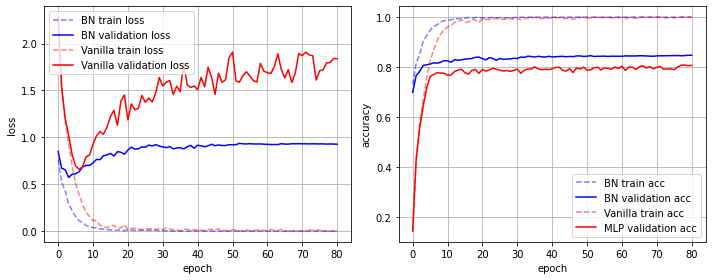

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(10,4))

# BN/Vanilla loss
ax[0].plot(np.arange(0, n_epochs+1), bn_trainloss, '--b', label='BN train loss' , alpha=0.5)
ax[0].plot(np.arange(0, n_epochs+1), bn_testloss, '-b', label='BN validation loss')
ax[0].plot(np.arange(0, n_epochs+1), van_trainloss, '--r', label='Vanilla train loss', alpha=0.5)
ax[0].plot(np.arange(0, n_epochs+1), van_testloss, '-r', label='Vanilla validation loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_xticks(np.arange(0,n_epochs+1,10))
ax[0].legend(loc='best')
ax[0].grid(True)

# CNN/MLP accuracy
ax[1].plot(np.arange(0, n_epochs+1), bn_trainacc, '--b', label='BN train acc' , alpha=0.5)
ax[1].plot(np.arange(0, n_epochs+1), bn_testacc, '-b', label='BN validation acc')
ax[1].plot(np.arange(0, n_epochs+1), van_trainacc, '--r', label='Vanilla train acc', alpha=0.5)
ax[1].plot(np.arange(0, n_epochs+1), van_testacc, '-r', label='MLP validation acc')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_xticks(np.arange(0,n_epochs+1,10))
ax[1].legend(loc='best')
ax[1].grid(True)

plt.tight_layout()
plt.savefig('./train_curves80.png')
plt.show()